# Out-of-core Text Classification Based on HashVectorizer.
When dealing with big data, the dataset and the intermediate result of the model training do not fit into memory. A possible solution consists in streaming the input documents with a generator so that we minimize the information that is stored in the memory.

#### Results

We get ~87% classification accuracy on the "ag news" dataset, with a Hashing Vectorizer and an SVM based on gradient descent. The state of the art for this dataset is ~92.5%. See for example
1. R. Johnson, T. Zhang, *Effective Use of Word Order for Text Categorization
with Convolutional Neural Networks*
2. X. Zhan, Y. LeCun, *Text Understanding from Scratch*

In [0]:
import itertools
import logging
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import preprocess_string 
import torch
import torch.nn as nn
import torch.optim as optim 
from scipy.sparse import coo_matrix

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

We do some preprocessing of the documents before feeding them to the vectorizer. The `doc_cleaner` is essential 

In [0]:
def doc_cleaner(doc):
    doc = doc.lower()               
    doc = re.sub(r'[^A-Z a-z]+', '', doc)
    doc = re.sub(' +', ' ', doc)  # multiple spaces
    doc = re.sub(r'http\S+', '', doc)  # URL    
    return doc

It's useful to have a helper class to stream the batches without having to put in the memory the whole corpus of documents, so I define a generator that iterates over batches of documents. It becomes a necessary step when the corpus does not fit into memory. 

In [0]:
class BatchedCorpus():
  def __init__(self, file_path:str):
      self._file_path = file_path
      
  def get_batch(self, start=0, batch_size=100, preprocess=None):
      """
          Args:
              start (int) = row index where the batch starts
              batch_size (int) = number of samples in the batch
              preprocess (function) = function to preprocess text, i.e., remove special symbols etc.
          Returns:
              tuple (document class (int), document title (str), text (str))
      """
      batch = []
      labels = []
      titles = []
      texts = []
      file = open(self._file_path, 'r') 
      for i, row in enumerate(itertools.islice(file, start, start + batch_size)):
        line = file.readline().split('","')
        labels.append(int(re.sub(r'[^0-9]+', '', line[0])))
        if preprocess:
          texts.append(preprocess(line[2]))
        else:
          texts.append(line[2])
      return labels, texts
  
  def iter_batch(self, batch_size=100, preprocess=None):
    start = 0
    i = 0
    labels, texts = self.get_batch(start, batch_size, preprocess)      
    while len(texts):
      yield labels, texts
      labels, texts = self.get_batch(i * batch_size, batch_size, preprocess)
      i = i + 1

# Main

In [0]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 14,
                                    alternate_sign=False)   
# prepare the test set, it's a small dataset so we just import it
test = pd.read_csv(r'/content/drive/My Drive/test.csv'.replace("\\", "/"), names=["label", "title", "text"])
test = test.sample(frac=1).reset_index(drop=True)
test.text.apply(doc_cleaner)
X_test = vectorizer.transform(test.text)

[SGD classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier)  is an sklearn class that implements several different *linear* classifiers and can be used for online (minibatch) training with stochastic gradient descent. As mentioned in the [documentation](https://scikit-learn.org/stable/modules/sgd.html#sgd), *`SGDClassifier` supports multi-class classification by combining multiple binary classifiers in a “one versus all” (OVA) scheme*. We use the *support vector* and the *logistic* classifiers. It is sufficient to change the loss function to switch between the two. By default `SGDClassifier` implements the linear SVM.

A higher regularization parameter `alpha` in the SGD classifiers is lowering the performance and leading to a slightly higher overfitting. The standard parameters seem to be a good compromise

The [Passive Aggressive](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier) classifier is an on-line learning algorithm suited for big data. The sklearn implementation implements a one-versus-rest (or OVA) policy for multiclass classification. 

After several attempts I lowered the regularization parameter `C` to increase the regularization.

In [42]:
BATCH_SIZE = 5000
train = BatchedCorpus(r'/content/drive/My Drive/train.csv'.replace("\\", "/"))

ova_SVM = SGDClassifier()
logistic = SGDClassifier(loss="log")
pac = PassiveAggressiveClassifier(C=.01, fit_intercept=True)  

classifiers = [ova_SVM, pac, logistic]
clf_names = ['SVM', 'PassiveAggressive', 'Logistic']

train_results = dict([(col, []) for col in clf_names])
test_results = dict([(col, []) for col in clf_names])

for epoch in range(6):
  print("Epoch {}".format(epoch + 1))
  optimizer.zero_grad() 
  for i, (labels, texts) in enumerate(train.iter_batch(preprocess=doc_cleaner,
                                                       batch_size=BATCH_SIZE)):

    # shuffle the batch
    args = np.random.randint(0, len(texts), len(texts))
    labels = np.asarray(labels)[args]
    texts = np.asarray(texts)[args]
    
    X = vectorizer.transform(texts)
    # train the classifiers
    for clf, name in zip(classifiers, clf_names):     
      clf.partial_fit(X, labels, np.unique(labels))   
      train_results[name].append(clf.score(X, labels))
      test_results[name].append(clf.score(X_test, test.label.values))                                 

  for clf, name in zip(classifiers, clf_names): 
    print("{}".format(name))
    print("train accuracy = {:1.6f}, test accuracy = {:1.6f}"
    .format(train_results[name][-1],
            test_results[name][-1]))      

  print(" ")    

Epoch 1
SVM
train accuracy = 0.909600, test accuracy = 0.863026
PassiveAggressive
train accuracy = 0.834000, test accuracy = 0.823553
Logistic
train accuracy = 0.868800, test accuracy = 0.841842
 
Epoch 2
SVM
train accuracy = 0.918000, test accuracy = 0.869474
PassiveAggressive
train accuracy = 0.872000, test accuracy = 0.847632
Logistic
train accuracy = 0.876000, test accuracy = 0.846447
 
Epoch 3
SVM
train accuracy = 0.918400, test accuracy = 0.869605
PassiveAggressive
train accuracy = 0.890800, test accuracy = 0.856316
Logistic
train accuracy = 0.884800, test accuracy = 0.845395
 
Epoch 4
SVM
train accuracy = 0.905600, test accuracy = 0.872763
PassiveAggressive
train accuracy = 0.889200, test accuracy = 0.863289
Logistic
train accuracy = 0.874800, test accuracy = 0.847237
 
Epoch 5
SVM
train accuracy = 0.902000, test accuracy = 0.872237
PassiveAggressive
train accuracy = 0.889200, test accuracy = 0.864211
Logistic
train accuracy = 0.870800, test accuracy = 0.846316
 
Epoch 6
SVM
tra

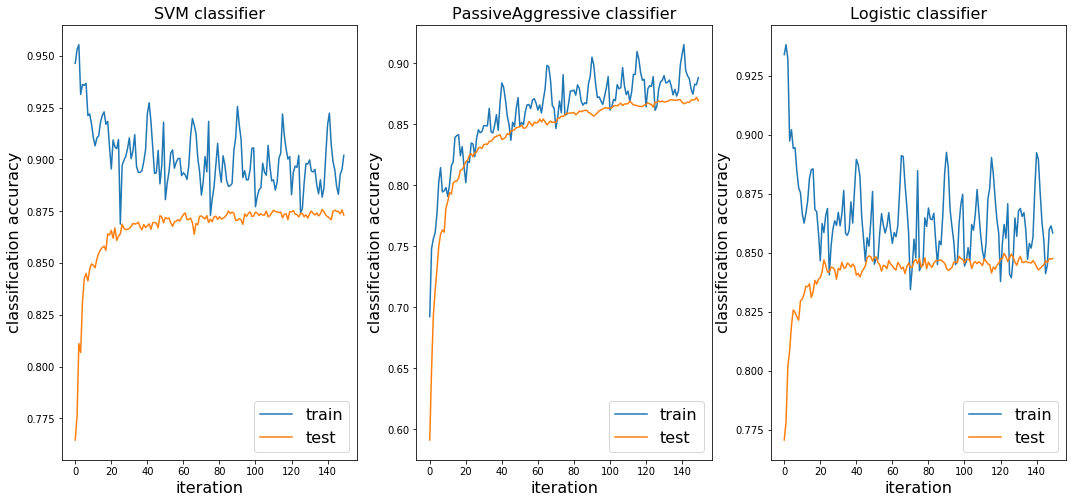

In [43]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 3, figsize=(18, 8))
for i, name in enumerate(clf_names):
  ax[i].plot(train_results[name], label='train')
  ax[i].plot(test_results[name], label='test')
  ax[i].set_title(name + " classifier", fontsize=16)
  ax[i].set_ylabel("classification accuracy", fontsize=16)
  ax[i].set_xlabel('iteration', fontsize=16)
  ax[i].legend(prop={'size': 16}, loc="lower right")